# Analysing arXiv papers using NLP and building a model

Every day, many scientific papers are published in ArXiV (https://arxiv.org/archive/astro-ph). 

In this notebook, we will use Natural Language Processing (NLP) to learn about those publications, what are the most used words or what about summarising abstracts.

In a second step, we will use deep learning model and try to predict citation numbers only from the abstract and the author list.

The arXiv makes its data available via a simple API which allows you to download almost everything about an article short of its full text. For the citations, we can find the information on [inspire](http://inspirehep.net/). 

In [3]:
import time
import datetime
from collections import Counter, defaultdict
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import pandas as pd
import urllib.request
import os,re
from concurrent.futures import ThreadPoolExecutor, as_completed
import tqdm
import requests
pd.set_option('mode.chained_assignment','warn')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

In [3]:
%matplotlib inline

The `df_data` function will query the arXiv API for all articles modified between two dates (onmy 2 yrs of data for CPU time). The API returns a big XML document containing information which we can parse with `ElementTree` and store. If there are more than 1000 articles for a particular query we can get those using the `resumptionToken` in the XML.  The information we harvest is stored in a `pandas` dataframe.

In [4]:
OAI = "{http://www.openarchives.org/OAI/2.0/}"
ARXIV = "{http://arxiv.org/OAI/arXiv/}"

def df_data(arxiv="physics:astro-ph", start_date="2010-01-01", end_date="2024-12-31"):
    """
    SL abstracts and metadata from arXiv using OAI-PMH.

    Args:
        arxiv (str): The arXiv set (e.g., "astro-ph").
        start_date (str): Start date in YYYY-MM-DD format.
        end_date (str): End date in YYYY-MM-DD format.

    Returns:
        pd.DataFrame: DataFrame containing metadata of papers.
    """
    df = pd.DataFrame(columns=["title", "abstract", "categories", "created", "id", "doi", "authors"])
    base_url = "http://export.arxiv.org/oai2?verb=ListRecords&"
    url = (base_url +
           f"from={start_date}&until={end_date}&" +
           f"metadataPrefix=arXiv&set={arxiv}")
    
    while True:
        print(f"Fetching: {url}")
        try:
            response = urllib.request.urlopen(url)
        except urllib.error.HTTPError as e:
            if e.code == 503:
                retry_after = int(e.headers.get("retry-after", 30))
                print(f"Got 503. Retrying after {retry_after} seconds.")
                time.sleep(retry_after)
                continue
            else:
                raise

        xml = response.read()
        root = ET.fromstring(xml)

        # Process each record
        records = root.find(OAI + 'ListRecords')
        if records is None:
            print("No records found. Exiting.")
            break

        for record in records.findall(OAI + "record"):
            try:
                meta = record.find(OAI + 'metadata')
                if meta is None:
                    continue

                info = meta.find(ARXIV + "arXiv")
                created = info.find(ARXIV + "created").text
                created = datetime.datetime.strptime(created, "%Y-%m-%d")
                categories = info.find(ARXIV + "categories").text.split()

                # Extract DOI
                doi = info.find(ARXIV + "doi")
                doi = doi.text.split()[0] if doi is not None else None

                # Extract authors
                authors = [author.text for author in info.findall(ARXIV + "authors/" + ARXIV + "author/" + ARXIV + "keyname")]
                author_list = ", ".join(authors)

                # Store the record
                contents = {
                    'title': info.find(ARXIV + "title").text.strip(),
                    'abstract': info.find(ARXIV + "abstract").text.strip(),
                    'categories': categories,
                    'created': created,
                    'id': info.find(ARXIV + "id").text.strip(),
                    'doi': doi,
                    'authors': author_list
                }

                df = pd.concat([df, pd.DataFrame([contents])], ignore_index=True)

            except Exception as e:
                print(f"Error processing record: {e}")
                continue

        # Check for resumptionToken to fetch next batch
        token = records.find(OAI + "resumptionToken")
        if token is None or token.text is None:
            break
        else:
            url = base_url + f"resumptionToken={token.text}"

    return df

    

To avoid scrapping all the data again, which take time, it is a good idea to store them. So we will run the df_data function only if there is not already a file called arxiv.parquet

In [2]:
#Check if file exist, otherwise run df_data and save file
if os.path.exists('arxiv.parquet'):
    df= pd.read_parquet('arxiv.parquet')

else:
    df = df_data(arxiv="physics:astro-ph", start_date="2018-01-01", end_date="2018-12-31")
    df.to_parquet("arxiv.parquet", engine="pyarrow", compression="snappy")
df.head()

,title,abstract,categories,created,id,doi,authors,citation,stemmed_abstract,stemmed_title,...,days_since_creation,citations_per_day,label,total_sentences,passive_sentences,passive_fraction,word_count,unique_word,novelty_counts,impact_counts
0,Periodicity of ~155 days in solar electron flu...,In this paper we have investigated the occurre...,[astro-ph],2007-06-06,0706.0838,None,"Chowdhury, Ray, Ray",1.0,"[in, thi, paper, we, have, investig, the, occu...","[period, of, ~155, day, in, solar, electron, f...",...,6446,0.000155,False,2,1,0.500000,96,44,1,1
1,PPN as Explosions: Bullets vs Jets and Nebular...,Many proto-planetary nebulae (PPN) appear as n...,[astro-ph],2007-07-11,0707.1641,10.1086/587730,"Dennis, Cunningham, Frank, Balick, Blackman, M...",19.0,"[mani, proto-planetari, nebula, (ppn), appear,...","[ppn, as, explosions:, bullet, vs, jet, and, n...",...,6411,0.002964,False,6,1,0.166667,194,81,0,0
2,Direct observation of high-speed plasma outflo...,Spectroscopic observations of a solar limb fla...,[astro-ph],2007-09-14,0709.2329,10.1086/519004,"Wang, Sui, Qiu",15.0,"[spectroscop, observ, of, a, solar, limb, flar...","[direct, observ, of, high-spe, plasma, outflow...",...,6346,0.002364,False,4,2,0.500000,117,56,2,1
3,Broad Line Emission in Low-Metallicity Blue Co...,We present spectra of a large sample of low-me...,[astro-ph],2007-09-23,0709.3643,10.1086/522923,"Izotov, Thuan, Guseva",49.0,"[we, present, spectra, of, a, larg, sampl, of,...","[broad, line, emiss, in, low-metal, blue, comp...",...,6337,0.007732,False,10,3,0.300000,260,97,0,0
4,Unstable Disk Accretion to Magnetized Stars: F...,We report on the first global three-dimensiona...,[astro-ph],2007-11-02,0711.0418,10.1086/527298,"Romanova, Kulkarni, Lovelace",92.0,"[we, report, on, the, first, global, three-dim...","[unstabl, disk, accret, to, magnet, stars:, fi...",...,6297,0.014610,False,8,2,0.250000,176,61,3,3


In [5]:
#Remove article with id with letters
df=df[df['id'].apply(lambda x: bool(re.match(r'^\d+(\.\d+)?$', str(x))))]

## Let's look


In [95]:
# First the size
print("Unique arXiv IDs edited in 2018:", len(df.id.unique()))

Unique arXiv IDs edited in 2018: 17258


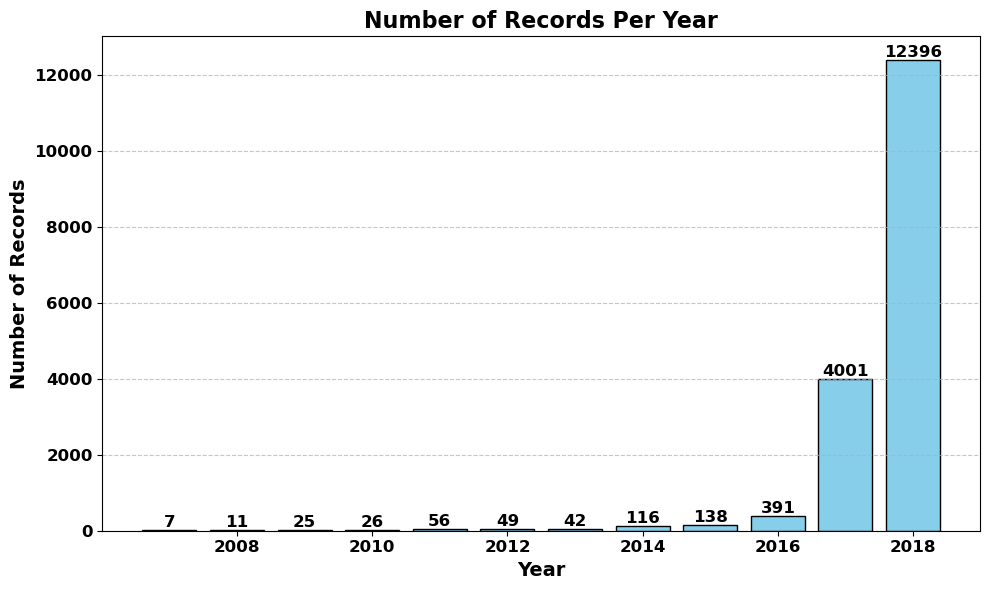

In [96]:
# Which year the articles have been created
year_counts = Counter(df.created.map(lambda x: x.year))
years = list(year_counts.keys())
counts = list(year_counts.values())
# Plotting

plt.figure(figsize=(10, 6))
bars = plt.bar(years, counts, color='skyblue', edgecolor='black')

# Adding values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f"{height}", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customizing axes and title
plt.xlabel("Year", fontsize=14, fontweight='bold')
plt.ylabel("Number of Records", fontsize=14, fontweight='bold')
plt.title("Number of Records Per Year", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

There are 17531 articles in `astro-ph` which were edited during 2018. Including about 12423 newly created articles. The other 5000 papers were created before 2018 and were updated after creation. Amazing to see that papers created in 2007 are still edited in 2018!!!



## Collecting citations

We create a function get_citation to obtain the citation from an article. Unfortunatelly, we can only do 5,000 requests per day using NADA ADS API. So we decide to use INSPIRE with a break of 5 seconds each batch.

In [75]:
token = os.environ.get("MY_NASA_ADS_PERSONAL_TOKEN")
token = 'gcF6fRBYXb7Rqe6DSdr3ggfhcNFaJnpQayhU9RI5'
def get_citation(arxiv_id):

    url = f"https://api.adsabs.harvard.edu/v1/search/query?q=arxiv:{arxiv_id}&fl=citation_count,title"
    print(url)
    headers = {"Authorization": f"Bearer {token}"}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        data = response.json()
        docs = data.get("response", {}).get("docs", [])
    return docs[0].get("citation_count", 0)




# Parallelized get_citation function
def parallel_get_citation(arxiv_id):
    return arxiv_id, get_citation(arxiv_id)
'''
# Use ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(tqdm.tqdm(executor.map(parallel_get_citation, df["id"]), total=len(df)))

# Convert results to a dictionary and map back
citation_dict = dict(results)
df['citation'] = df['id'].map(citation_dict).fillna(df['citation'])
'''

'\n# Use ThreadPoolExecutor\nwith ThreadPoolExecutor(max_workers=10) as executor:\n    results = list(tqdm.tqdm(executor.map(parallel_get_citation, df["id"]), total=len(df)))\n\n# Convert results to a dictionary and map back\ncitation_dict = dict(results)\ndf[\'citation\'] = df[\'id\'].map(citation_dict).fillna(df[\'citation\'])\n'

In [ ]:
failed_cite = df[df['citation'].isnull()]
with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(tqdm.tqdm(executor.map(parallel_get_citation, failed_cite["id"]), total=len(failed_cite)))

In [ ]:
from scholarly import scholarly
import random

def get_citation_count(title):
    """Fetch the citation count for a paper by its title."""
    search_query = scholarly.search_pubs(title)
    result = next(search_query, None)
    return result['num_citations']

def process_title(title):
    """
    Wrapper to process a single title and introduce random delays to respect rate limits.
    """
    citation_count = get_citation_count(title)
    time.sleep(random.uniform(5, 15))  # Randomized delay
    return title, citation_count
    
def batch_process_titles(titles, output_file, max_workers=5):
    """
    Process titles in parallel and save results to a CSV file.
    
    Args:
        titles: List of paper titles.
        output_file: Path to the output CSV file.
        max_workers: Number of parallel threads to use.
    """
    with ThreadPoolExecutor(max_workers=max_workers) as executor, open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Title', 'Citations'])  # Header row
        
        # Submit tasks for each title
        future_to_title = {executor.submit(process_title, title): title for title in titles}
        
        # Process results as they complete
        for future in as_completed(future_to_title):
            title = future_to_title[future]
            try:
                title, citation_count = future.result()
                print(f"Processed: {title} -> {citation_count} citations")
                writer.writerow([title, citation_count])  # Save result to file
            except Exception as e:
                print(f"Error processing title '{title}': {e}")

# Example: List of titles (replace with actual titles from your DataFrame)
titles = df.title

# Process in parallel and save results to a CSV
batch_process_titles(titles, 'citation_counts.csv', max_workers=5)    


In [153]:
def get_citation_count(arxiv_ids):
    """Fetch citation counts for a batch of ArXiv IDs using the INSPIRE REST API."""
    # Deduplicate ArXiv IDs to avoid redundant queries
    arxiv_ids = list(set(arxiv_ids))
    
    url = "https://inspirehep.net/api/literature"
    query = ' OR '.join([f'arxiv:{arxiv_id}' for arxiv_id in arxiv_ids])
    
    # Query parameters
    params = {
        'q': query,
        'fields': 'arxiv_eprints,citation_count'
    }

    # Make the request
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        result = {}

        # Process each document in the response
        for doc in data.get('hits', {}).get('hits', []):
            # Extract ArXiv IDs and citation count
            arxiv_eprints = doc.get('metadata', {}).get('arxiv_eprints', [])
            citation_count = doc.get('metadata', {}).get('citation_count', 0)
            
            # Map citation counts to ArXiv IDs
            for entry in arxiv_eprints:
                arxiv_value = entry.get("value")
                if arxiv_value:  # Ensure the ArXiv ID exists
                    result[arxiv_value] = citation_count

        return result

def process_batches_in_parallel(arxiv_ids, batch_size=14, max_workers=5):
    """Parallelize the fetching of citation counts for a list of ArXiv IDs."""
    results = {}
    batches = [arxiv_ids[i:i + batch_size] for i in range(0, len(arxiv_ids), batch_size)]
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_batch = {executor.submit(get_citation_count, batch): batch for batch in batches}
        for future in as_completed(future_to_batch):
            batch = future_to_batch[future]
            try:
                batch_results = future.result()
                results.update(batch_results)
            except Exception as e:
                print(f"Error processing batch {batch}: {e}")
            finally:
                time.sleep(5)  # Adjust based on API limits (keep it minimal to maintain performance)
    
    return results

In [ ]:
if 'citation' in df.columns:
    df= pd.read_parquet('arxiv.parquet')
else:
    print("Search citation count using inspire webpage")
    # Initial batch processing
    results = process_batches_in_parallel(df['id'].tolist(), batch_size=14, max_workers=5)
    results_df = pd.DataFrame(list(results.items()), columns=['id', 'citation'])
    df = pd.merge(df, results_df, how='left', on='id')
    
    # Retry processing for articles with NaN citations up to 5 times
    max_retries = 15
    for retry in range(max_retries):
        print(f"Retry attempt {retry + 1}...")
        failed_cite = df[df['citation'].isnull()]['id'].tolist()
        
        if not failed_cite:
            print("No more failed citations to process.")
            break  # Exit the loop if there are no failed citations
        
        # Process the failed citations
        results = process_batches_in_parallel(failed_cite, batch_size=14, max_workers=5)
        results_df = pd.DataFrame(list(results.items()), columns=['id', 'citation'])
        
        # Merge the new results back into the DataFrame
        df = pd.merge(df, results_df, how='left', on='id', suffixes=('', '_new'))
        df['citation'] = df['citation'].combine_first(df['citation_new'])
        df = df.drop(columns=['citation_new'])

df


In [ ]:
# Base URL for arXiv API
BASE_URL = "http://export.arxiv.org/api/query"

# Function to fetch metadata for a batch of arXiv IDs
def fetch_arxiv_metadata(batch_ids):
    query = ",".join(batch_ids)
    params = {
        "id_list": query
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        return response.text
    else:
        return None

# Parse the metadata from the API response
def parse_metadata(response_text):
    import xml.etree.ElementTree as ET
    root = ET.fromstring(response_text)
    entries = root.findall("{http://www.w3.org/2005/Atom}entry")
    metadata_list = []
    for entry in entries:
        arxiv_id = entry.find("{http://www.w3.org/2005/Atom}id").text.split("/")[-1]
        title = entry.find("{http://www.w3.org/2005/Atom}title").text.strip()
        authors = ", ".join([author.find("{http://www.w3.org/2005/Atom}name").text for author in entry.findall("{http://www.w3.org/2005/Atom}author")])
        published = entry.find("{http://www.w3.org/2005/Atom}published").text
        summary = entry.find("{http://www.w3.org/2005/Atom}summary").text.strip()
        journal_ref = entry.find("{http://arxiv.org/schemas/atom}journal_ref")
        journal_ref = journal_ref.text if journal_ref is not None else "N/A"
        metadata_list.append({
            "arxiv_id": arxiv_id,
            "title": title,
            "authors": authors,
            "published": published,
            "journal_ref": journal_ref,
            "summary": summary,
        })
    return metadata_list

# Process arXiv IDs in batches
batch_size = 100  # Adjust based on your needs (max 300 per arXiv guidelines)
with open(output_file, "w", newline="") as csvfile:
    fieldnames = ["arxiv_id", "title", "authors", "published", "journal_ref", "summary"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for i in range(0, len(arxiv_ids), batch_size):
        batch_ids = arxiv_ids[i:i + batch_size]
        print(f"Processing batch {i // batch_size + 1}: {batch_ids}")
        response_text = fetch_arxiv_metadata(batch_ids)
        if response_text:
            metadata_list = parse_metadata(response_text)
            writer.writerows(metadata_list)
        else:
            print(f"Failed to fetch metadata for batch {batch_ids}")
        time.sleep(1)  # Pause to avoid overwhelming the API

print(f"Metadata saved to {output_file}")

## Analyse the abstracts

To answer some questions like for example, what are the ten most used words in abstracts, we need to first transform the abstracts.
First, we will ensure that all text in the abstract column is converted to lowercase. This can be useful for text preprocessing in tasks like text classification or analysis. Then, we will concatenate all the elements into a single string, with each abstract separated by a space. This combines all the abstracts into one large string of text where individual abstracts are separated by spaces (called tot_abs). Finally, we count the words and select the most 10 common.

In [80]:
tot_abs = " ".join(df.abstract.apply(lambda t: t.lower()))

Counter(tot_abs.split(" ")).most_common(n=10)


[('the', 224944),
 ('of', 130223),
 ('and', 76353),
 ('a', 62040),
 ('in', 61905),
 ('to', 56404),
 ('we', 45635),
 ('with', 32663),
 ('is', 32344),
 ('that', 29731)]

The most common words used in the abstracts are not too enlightening. These words are known as stopwords and thanksfully, `NLTK` library provides a list of all of them so we can remove them easily.

In [81]:
import nltk 
from nltk.corpus import stopwords
# Print the list of stopwords in English
stops = [word for word in stopwords.words('english')]
print(stops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [82]:
#We remove the stopwords and look at the most 20 used words
words_all = [w for w in tot_abs.split() if w not in stops]
top_twenty = Counter(words_all).most_common(n=20)

print(top_twenty)

[('mass', 8531), ('using', 7664), ('find', 7398), ('data', 7051), ('also', 6752), ('stellar', 6707), ('model', 6634), ('star', 6338), ('stars', 6276), ('present', 5879), ('observed', 5781), ('show', 5765), ('galaxies', 5736), ('emission', 5616), ('observations', 5606), ('two', 5592), ('magnetic', 5192), ('field', 5146), ('results', 5082), ('large', 4904)]


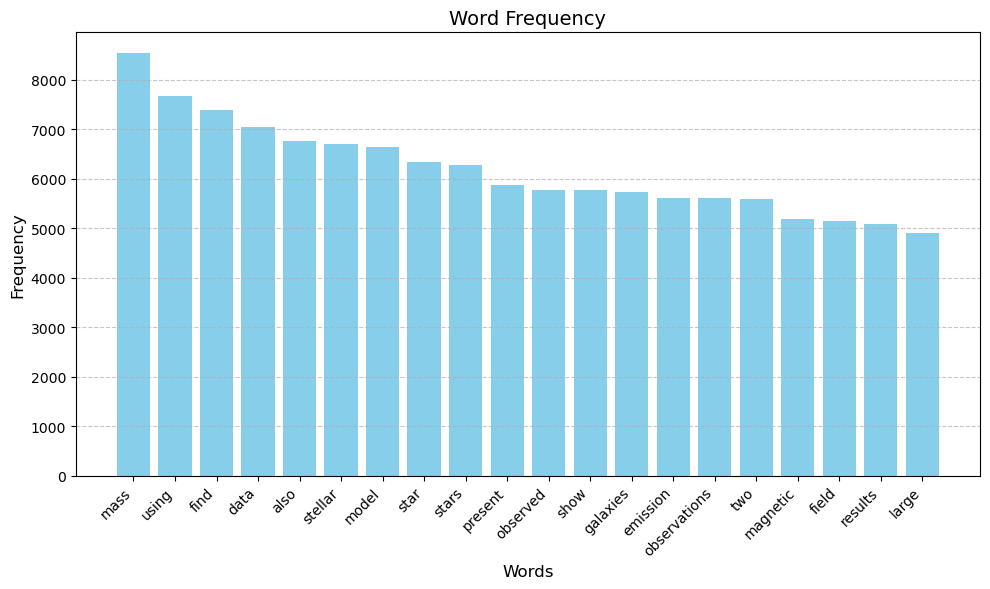

In [83]:
words_hist, counts_hist=zip(*top_twenty)
# Plot
plt.figure(figsize=(10, 6))
plt.bar(words_hist, counts_hist, color='skyblue')

# Formatting
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Word Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display
plt.tight_layout()
plt.show()

The most used words are somewhat expected. In astronomy, you do observations, you measure mass, see galaxies, starts and you hopefully have results :-).
However, we have `observed` and `observations` or `star` and `stars`. These should probably be counted as one entry. 

There are two techniques to normalize the text: stemming and lemming

### Stemming

It is the process of reducing infected words to their stem. For instance, in figure 1, stemming with replace words “history” and “historical” with “histori”. Before, stemming, tokenization is done so as to break text into chunks. In this case, paragraph to sentences for easy computation.

In [84]:
# Let's do an exemple ot illustrate this

import nltk.stem as stem
stemmer = stem.PorterStemmer()
for w in ("measurement", "measurements", "measured", "measure"):
    print (w, "->", stemmer.stem(w))

measurement -> measur
measurements -> measur
measured -> measur
measure -> measur


In [85]:
stem2words = defaultdict(set)
stems = []
for word in words_all:
    stem = stemmer.stem(word)
    stem2words[stem].add(word)
    stems.append(stem)

# Count stems and get the 20 most common
top_twenty = Counter(stems).most_common(n=20)
print(top_twenty)

[('observ', 15517), ('use', 14393), ('star', 12614), ('model', 12597), ('galaxi', 10635), ('mass', 10406), ('find', 8284), ('show', 7915), ('result', 7536), ('data', 7051), ('present', 6832), ('also', 6752), ('stellar', 6708), ('field', 6583), ('measur', 6415), ('detect', 6306), ('studi', 6293), ('emiss', 5897), ('magnet', 5636), ('two', 5592)]


In [86]:
# list all words which correspond to each top twenty stem
for ste,count in top_twenty:
    print (ste, "<-", ", ".join(stem2words[ste]))

observ <- observe, observed, observers, observables, observes, observing, observations, observably, observational, observability, observationally, observable, observation, observer
use <- used, using, useful, use, usefully, uses, usefulness
star <- stars, star
model <- modeling, modelling, modeled, model, models, modelers, modelled, modelings, modellers
galaxi <- galaxys, galaxies, galaxy
mass <- mass, masses
find <- findings, finds, find, finding
show <- show, showe, showing, shows, showed
result <- resulted, resultant, result, results, resulting
data <- data
present <- presenting, presentations, presented, presentation, present, presents, presenter, presently
also <- also
stellar <- stellarator, stellar
field <- fields, field, fielding, fielded
measur <- measured, measurements, measures, measuring, measurably, measurable, measurement, measure
detect <- detectible, detection, detective, detectable, detecting, detect, detections, detectivity, detectability, detectably, detects, detecte

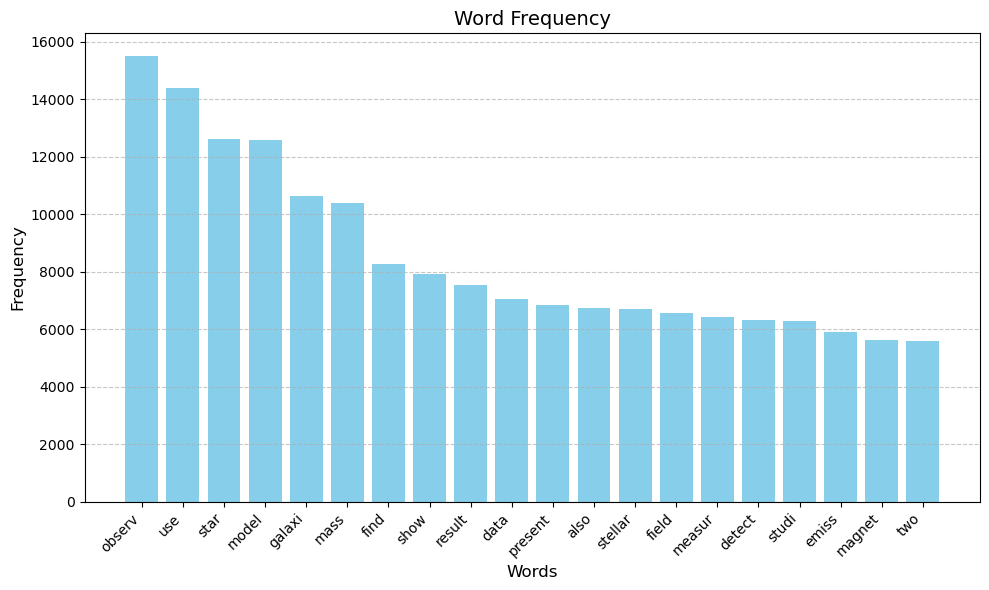

In [87]:
words_hist, counts_hist=zip(*top_twenty)
# Plot
plt.figure(figsize=(10, 6))
plt.bar(words_hist, counts_hist, color='skyblue')

# Formatting
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Word Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display
plt.tight_layout()
plt.show()

you have more observational paper than from theory

### Lemmatization

In stemming, for some words, it may not give may not give meaningful representation such as “Histori”. Here, lemmatization comes into picture as it gives meaningful word. Lemmatization takes more time as compared to stemming because it finds meaningful word/ representation

In [88]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
for w in ("measurement", "measurements", "measured", "measure",'measuring'):
    print (w, "->", lemmatizer.lemmatize(w,pos='v'))

[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


measurement -> measurement
measurements -> measurements
measured -> measure
measure -> measure
measuring -> measure


In [89]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Generate lemmas and map them to words in a single pass
lemma2words = defaultdict(set)
lemmas = []
for word in words_all:
    lemma = lemmatizer.lemmatize(word,pos='v')
    lemma2words[lemma].add(word)
    lemmas.append(lemma)

# Count lemmas and get the 20 most common
top_twenty_lem = Counter(lemmas).most_common(n=20)
print(top_twenty_lem)

[('use', 13944), ('star', 12616), ('model', 12593), ('find', 11352), ('mass', 10406), ('show', 8718), ('result', 7481), ('data', 7051), ('present', 6758), ('also', 6752), ('observe', 6744), ('stellar', 6707), ('field', 6583), ('study', 6293), ('galaxies', 5736), ('emission', 5616), ('observations', 5606), ('two', 5592), ('magnetic', 5192), ('cluster', 4926)]


The stemming is not perfect, but good enough and for our purpose, it is better than the lemmatization.

### Search for particular topic.

I am very interested by supernovae, so I will only look at the abstracts mentionning supernovae

In [197]:
# Initialize the stemmer
import nltk.stem as stem
stemmer = stem.PorterStemmer()

# Keyword for search
search_keyword = "supernovae"

# Stem the keyword
search_stem = stemmer.stem(search_keyword.lower())

# Create a new column with stemmed abstracts
df['stemmed_title'] = df['title'].apply(lambda abstract: [stemmer.stem(word.lower()) for word in abstract.split()])

df['stemmed_abstract'] = df['abstract'].apply(lambda abstract: [stemmer.stem(word.lower()) for word in abstract.split()])



# Filter the DataFrame for abstracts mentioning "supernovae" or similar terms
matching_abstracts = df[df['stemmed_abstract'].apply(lambda stemmed_words: search_stem in stemmed_words)]

# Drop the helper column for clean output
matching_abstracts = matching_abstracts.drop(columns=['stemmed_abstract'])

# The resulting DataFrame with relevant abstracts
matching_abstracts.reset_index(drop=True, inplace=True)
matching_abstracts

,title,abstract,categories,created,id,doi,authors,citation,stemmed_title,keywords,days_since_creation,citations_per_day
0,PPN as Explosions: Bullets vs Jets and Nebular...,Many proto-planetary nebulae (PPN) appear as n...,[astro-ph],2007-07-11,0707.1641,10.1086/587730,"Dennis, Cunningham, Frank, Balick, Blackman, M...",19.0,"[ppn, as, explosions:, bullet, vs, jet, and, n...","[gamma-ray bursts, dark matter]",6411,0.002964
1,Broad Line Emission in Low-Metallicity Blue Co...,We present spectra of a large sample of low-me...,[astro-ph],2007-09-23,0709.3643,10.1086/522923,"Izotov, Thuan, Guseva",49.0,"[broad, line, emiss, in, low-metal, blue, comp...","[dwarf galaxies, interstellar medium]",6337,0.007732
2,Active galactic nuclei in four metal-poor dwar...,We present 3.5m Apache Point Observatory secon...,[astro-ph],2008-07-13,0807.2029,10.1086/591660,"Izotov, Thuan",38.0,"[activ, galact, nuclei, in, four, metal-poor, ...","[dark matter, dark energy]",6043,0.006288
3,Near-infrared spectroscopy of the Blue Compact...,We present near-infrared (NIR) spectroscopic o...,[astro-ph.CO],2009-08-18,0908.2535,10.1088/0004-637X/703/2/1984,"Izotov, Thuan, Wilson",7.0,"[near-infrar, spectroscopi, of, the, blue, com...","[starburst galaxies, dark matter]",5642,0.001241
4,Cyclotron harmonics in opacities of isolated n...,Some of X-ray dim isolated neutron stars (XDIN...,"[astro-ph.HE, astro-ph.SR, physics.plasm-ph]",2010-03-26,1003.5106,10.1051/0004-6361/201014781,Potekhin,15.0,"[cyclotron, harmon, in, opac, of, isol, neutro...","[dark matter, dark energy]",5422,0.002767
...,...,...,...,...,...,...,...,...,...,...,...,...
1075,Remnants and ejecta of thermonuclear electron-...,(Abridged) The explosion mechanism of electron...,"[astro-ph.SR, astro-ph.HE]",2018-12-19,1812.08230,10.1051/0004-6361/201834381,"Jones, Roepke, Fryer, Ruiter, Seitenzahl, Nitt...",41.0,"[remnant, and, ejecta, of, thermonuclear, elec...","[interstellar medium, supernovae]",2232,0.018369
1076,Global Constraints on Diffusive Particle Accel...,Estimating the cosmic-ray acceleration efficie...,[astro-ph.HE],2018-12-20,1812.08395,10.1093/mnras/sty3136,"Zhang, Liu",6.0,"[global, constraint, on, diffus, particl, acce...","[dark matter, dark energy]",2231,0.002689
1077,Excluding super-soft X-ray sources as progenit...,Type Ia supernovae are vital to our understand...,[astro-ph.HE],2018-12-20,1812.08799,10.1093/mnras/stz065,"Kuuttila, Gilfanov, Seitenzahl, Woods, Vogt",11.0,"[exclud, super-soft, x-ray, sourc, as, progeni...","[white dwarfs, interstellar medium]",2231,0.004931
1078,Transfer Learning in Astronomy: A New Machine-...,The widespread dissemination of machine learni...,"[astro-ph.HE, astro-ph.IM, cs.LG]",2018-12-20,1812.10403,None,Vilalta,3.0,"[transfer, learn, in, astronomy:, a, new, mach...","[dark matter, dark energy]",2231,0.001345


Now I would like to find all the papers in supernovae for which I have been an author

In [174]:
# Specify the author you are looking for
author_name = "Riess"  # Replace with the name you are searching for

# Filter rows where the author appears in the 'authors' column
matching_authors = matching_abstracts[matching_abstracts['authors'].apply(lambda authors: author_name.lower() in authors.lower())]

# Display the matching rows
print(matching_authors)

                                                  title  \
135   Investigating Galactic supernova remnant candi...   
137   Extreme magnification of a star at redshift 1....   
167   Hydrogen-Poor Superluminous Supernovae from th...   
211   Type Ia Supernova Distances at z > 1.5 from th...   
212   The Complete Light-curve Sample of Spectroscop...   
213   Measuring Dark Energy Properties with Photomet...   
218   Cosmic ray signatures of a 2-3 Myr old local s...   
263   Observations of SN 2015F suggest a correlation...   
268   The Foundation Supernova Survey: Motivation, D...   
555   Unveiling the dynamical state of massive clust...   
685   Should Type Ia Supernova Distances be Correcte...   
868   Late-Time Observations of ASASSN-14lp Strength...   
1042  Photometric and Spectroscopic Properties of Ty...   
1043  K2 Observations of SN 2018oh Reveal a Two-Comp...   
1061  Vela as the Source of Galactic Cosmic Rays abo...   

                                               abstract

We will select keywords from review and assign to each paper 2 keywords

In [178]:
def assign_keywords_stemmed(data, keywords):

    # Combine stemmed_title and stemmed_abstract into one string for matching
    combined_text = ' '.join(data['stemmed_title'] + data['stemmed_abstract'])
    # Count occurrences of each stemmed keyword in the combined text
    keyword_counter = Counter()
    
    for keyword in keywords:
        # Use regular expression to match whole words (word boundaries)
        matches = re.findall(r'\b' + re.escape(keyword) + r'\b', combined_text)
        keyword_counter[keyword] += len(matches)
    
    # Get the most common keywords
    most_common_keywords = [keyword for keyword, _ in keyword_counter.most_common()]
    
    # Return the list of most common keywords
    return most_common_keywords[0:2]

In [179]:
keywords = [
        "dark matter", "dark energy", "cosmic microwave background",
        "Hubble constant", "redshift", "large-scale structure", "structure formation",
        "spiral galaxies", "elliptical galaxies", "dwarf galaxies",
        "active galactic nuclei", "supermassive black holes", "quasars", "starburst galaxies",
        "interstellar medium", "molecular clouds", "star formation rate",
        "stellar feedback", "protoplanetary disks",
        "stellar evolution", "main sequence stars", "red giants", 
        "supernovae", "white dwarfs", "neutron stars", "binary systems",
        "exoplanet detection", "transit method", "radial velocity method",
        "planetary atmospheres", "habitable zones", "circumstellar disks",
        "spectroscopy", "photometry", "surveys", "telescopes", "data analysis methods",
        "gamma-ray bursts", "X-ray astronomy", "jets",
        "compact objects", "gravitational waves",
        "astronomical databases", "machine learning", "observations", "numerical simulations"
    ]


In [180]:
# Initialize stemmer
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")
# Stem the keywords
stemmed_keywords = [stemmer.stem(keyword) for keyword in keywords]
stemmed_keywords

['dark matt',
 'dark energi',
 'cosmic microwave background',
 'hubble const',
 'redshift',
 'large-scale structur',
 'structure form',
 'spiral galaxi',
 'elliptical galaxi',
 'dwarf galaxi',
 'active galactic nuclei',
 'supermassive black hol',
 'quasar',
 'starburst galaxi',
 'interstellar medium',
 'molecular cloud',
 'star formation r',
 'stellar feedback',
 'protoplanetary disk',
 'stellar evolut',
 'main sequence star',
 'red giant',
 'supernova',
 'white dwarf',
 'neutron star',
 'binary system',
 'exoplanet detect',
 'transit method',
 'radial velocity method',
 'planetary atmospher',
 'habitable zon',
 'circumstellar disk',
 'spectroscopi',
 'photometri',
 'survey',
 'telescop',
 'data analysis method',
 'gamma-ray burst',
 'x-ray astronomi',
 'jet',
 'compact object',
 'gravitational wav',
 'astronomical databas',
 'machine learn',
 'observ',
 'numerical simul']

In [376]:
df['keywords'] = df.apply(assign_keywords_stemmed, axis=1, keywords=stemmed_keywords)

I will add a columns, citations/days since creation

In [ ]:
# Convert the 'created' column to datetime
df['created'] = pd.to_datetime(df['created'])
# Get the current date
current_date = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'))

# Calculate the number of days since creation
df['days_since_creation'] = (current_date - df['created']).dt.days

# Calculate citations per day
df['citations_per_day'] = df['citation'] / df['days_since_creation']


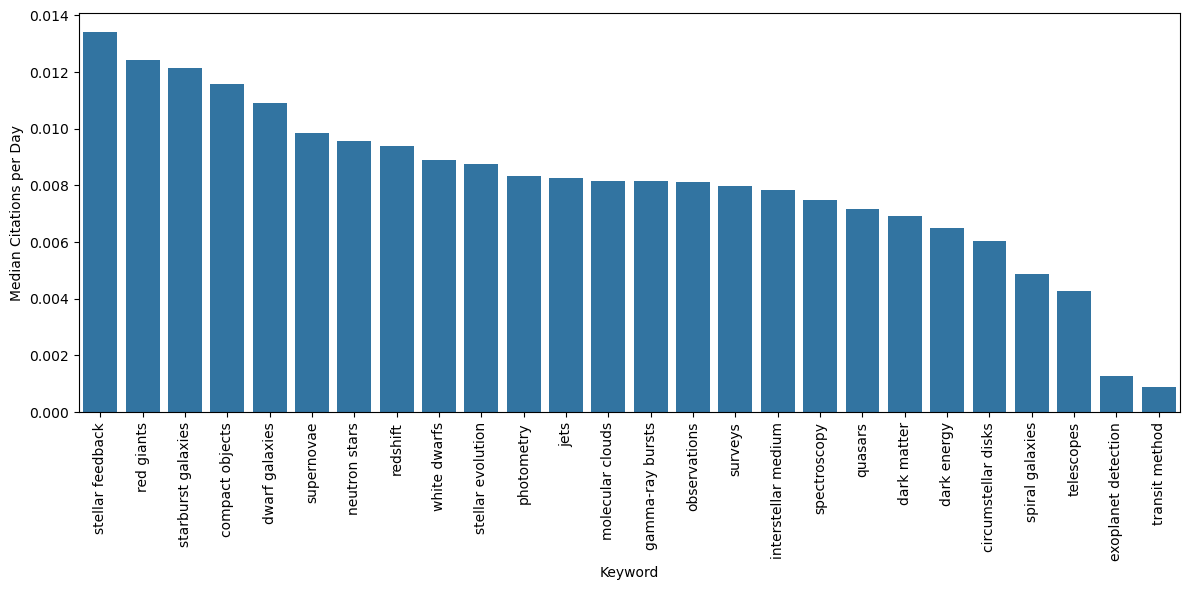

In [204]:
import seaborn as sns
# Flatten the list of keywords and repeat the citations_per_day value for each keyword
keyword_rows = []
for index, row in df.iterrows():
    for keyword in row['keywords']:
        keyword_rows.append({'keyword': keyword, 'citations_per_day': row['citations_per_day']})

# Create a new DataFrame from the keyword rows
keywords_df = pd.DataFrame(keyword_rows)

# Group by keyword and calculate the mean and std of citations_per_day
keyword_stats = keywords_df.groupby('keyword')['citations_per_day'].agg(['median', 'std']).reset_index()

# Sort by mean citations per day for better visualization
keyword_stats = keyword_stats.sort_values('median', ascending=False)

# Set up the figure
plt.figure(figsize=(12, 6))

# Plotting the mean
sns.barplot(data=keyword_stats, x='keyword', y='median')


# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set labels and title
plt.xlabel('Keyword')
plt.ylabel('Median Citations per Day')

# Show the plot
plt.tight_layout()
plt.show()

In [213]:
df.sort_values(by='citations_per_day',ascending=False)

,title,abstract,categories,created,id,doi,authors,citation,stemmed_abstract,stemmed_title,keywords,days_since_creation,citations_per_day
10758,Dark Matter Search Results from a One Tonne$\t...,We report on a search for Weakly Interacting M...,"[astro-ph.CO, astro-ph.IM, hep-ex, hep-ph, phy...",2018-05-31,1805.12562,10.1103/PhysRevLett.121.111302,"Aprile, Aalbers, Agostini, Alfonsi, Althueser,...",2359.0,"[we, report, on, a, search, for, weakli, inter...","[dark, matter, search, result, from, a, one, t...","[dark matter, dark energy]",2434,0.969187
5134,"The Astropy Project: Building an inclusive, op...",The Astropy project supports and fosters the d...,[astro-ph.IM],2018-01-08,1801.02634,10.3847/1538-3881/aabc4f,"The Astropy Collaboration, Price-Whelan, Sipőc...",2427.0,"[the, astropi, project, support, and, foster, ...","[the, astropi, project:, build, an, inclusive,...","[dark matter, dark energy]",2577,0.941793
1465,GW170104: Observation of a 50-Solar-Mass Binar...,"We describe the observation of GW170104, a gra...","[gr-qc, astro-ph.HE]",2017-06-06,1706.01812,10.1103/PhysRevLett.118.221101,"The LIGO Scientific Collaboration, the Virgo C...",2579.0,"[we, describ, the, observ, of, gw170104,, a, g...","[gw170104:, observ, of, a, 50-solar-mass, bina...","[redshift, dark matter]",2793,0.923380
10667,GW170817: Measurements of Neutron Star Radii a...,"On 17 August 2017, the LIGO and Virgo observat...","[gr-qc, astro-ph.HE]",2018-05-29,1805.11581,10.1103/PhysRevLett.121.161101,"The LIGO Scientific Collaboration, the Virgo C...",2238.0,"[on, 17, august, 2017,, the, ligo, and, virgo,...","[gw170817:, measur, of, neutron, star, radii, ...","[neutron stars, dark matter]",2436,0.918719
2605,The Complete Light-curve Sample of Spectroscop...,"We present optical light curves, redshifts, an...",[astro-ph.CO],2017-10-02,1710.00845,10.3847/1538-4357/aab9bb,"Scolnic, Jones, Rest, Pan, Chornock, Foley, Hu...",2286.0,"[we, present, optic, light, curves,, redshifts...","[the, complet, light-curv, sampl, of, spectros...","[photometry, dark energy]",2675,0.854579
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8290,"Leptogenesis, dark matter and neutrino masses",We review the viability of the sterile neutrin...,"[hep-ph, astro-ph.CO]",2018-03-28,1803.10826,None,"Lucente, Abada, Arcadi, Domcke",0.0,"[we, review, the, viabil, of, the, steril, neu...","[leptogenesis,, dark, matter, and, neutrino, m...","[dark matter, dark energy]",2498,0.000000
8243,Investigating Planet Formation and Evolutionar...,From wispy gas giants on the verge of disrupti...,[astro-ph.EP],2018-03-27,1803.10293,None,"Jackson, Adams, Heller, Endl",0.0,"[from, wispi, ga, giant, on, the, verg, of, di...","[investig, planet, format, and, evolutionari, ...","[dark matter, dark energy]",2499,0.000000
8255,Magrathea: Dust growth experiment in micro-gra...,One of the least understood processes in astro...,[astro-ph.IM],2018-03-28,1803.10477,None,"Guerra, García, Esteban, Fabozzi, Goli, Greif,...",0.0,"[one, of, the, least, understood, process, in,...","[magrathea:, dust, growth, experi, in, micro-g...","[dark matter, dark energy]",2498,0.000000
11798,Astrophysical Nuclear Reactions: from Hydrogen...,The work reported in this dissertation will co...,"[astro-ph.SR, astro-ph.HE]",2018-06-28,1806.11179,None,Cuda,0.0,"[the, work, report, in, thi, dissert, will, co...","[astrophys, nuclear, reactions:, from, hydroge...","[dark matter, dark energy]",2406,0.000000


In [216]:
#Let check the papers with stellar feedback as keyword:
# Filter the dataframe for rows where 'compact object' is in the 'keywords' column
stellar_feedback_papers = df[df['keywords'].apply(lambda x: 'stellar feedback' in x)]

# Display the filtered dataframe
print(stellar_feedback_papers)

                                                   title  \
162    Dwarf Galaxies with Ionizing Radiation Feedbac...   
165    Dwarf Galaxies with Ionizing Radiation Feedbac...   
268              Cloud and Star Formation in Spiral Arms   
586    Cosmological hydrodynamical simulations of gal...   
701    Why do high-redshift galaxies show diverse gas...   
...                                                  ...   
16280  Quantifying inhomogeneities in the HI distribu...   
16399  Compressed magnetic field in the magnetically-...   
16476  Extreme fragmentation and complex kinematics a...   
16743       The Origin of Interstellar Turbulence in M33   
16999  The integrated properties of the molecular clo...   

                                                abstract  \
162    We describe a new method for simulating ionizi...   
165    We investigate the spatially-resolved star for...   
268    We present the results from simulations of GMC...   
586    We analyse cosmological hydrodyn

### Summarize an abstract

I will how we can summarize an abstract

In [302]:
from transformers import pipeline

# Load the summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
summary = summarizer(df.iloc[2605].abstract, max_length=100, min_length=20, do_sample=False)

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.
/home/tdejaege/anaconda3/envs/lemaitre/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [303]:
df.iloc[2605].abstract

"We present optical light curves, redshifts, and classifications for 365\nspectroscopically confirmed Type Ia supernovae (SNe Ia) discovered by the\nPan-STARRS1 (PS1) Medium Deep Survey. We detail improvements to the PS1 SN\nphotometry, astrometry and calibration that reduce the systematic uncertainties\nin the PS1 SN Ia distances. We combine the subset of 279 PS1 SN Ia ($0.03 < z <\n0.68$) with useful distance estimates of SN Ia from SDSS, SNLS, various low-z\nand HST samples to form the largest combined sample of SN Ia consisting of a\ntotal of 1048 SN Ia ranging from $0.01 < z < 2.3$, which we call the `Pantheon\nSample'. When combining Planck 2015 CMB measurements with the Pantheon SN\nsample, we find $\\Omega_m=0.307\\pm0.012$ and $w = -1.026\\pm0.041$ for the wCDM\nmodel. When the SN and CMB constraints are combined with constraints from BAO\nand local H0 measurements, the analysis yields the most precise measurement of\ndark energy to date: $w0 = -1.007\\pm 0.089$ and $wa = -0.2

In [304]:
print("Summary:", summary[0]['summary_text'])

Summary: We present optical light curves, redshifts, and classifications for 365spectroscopically confirmed Type Ia supernovae (SNe Ia) discovered by the Pan-STARRS1 (PS1) Medium Deep Survey. Tension with a cosmological constant previously seen in an analysis of PS1 and low-z SNe has diminished after an increase in statistics.


# Let's try to find correlations between citations and some features 

Does the number of citations depends on the number of words in the abstract, title? Does abstract depends on the passive/active sentences? number of unique words excluding stop words?

In [357]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag

# Download necessary NLTK models (only needed once)
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

stop_words = set(stopwords.words("english"))
def is_passive(sentence):
    """Determine if a sentence is in passive voice."""
    words = word_tokenize(sentence)
    tagged = pos_tag(words) #e.g., noun, verb, adjective)

    be_verbs = {"is", "was", "were", "are", "been", "being"}
    past_participle = {"VBN"}

    for i in range(len(tagged) - 1):
        word, tag = tagged[i]
        next_word, next_tag = tagged[i + 1]

        if word.lower() in be_verbs and next_tag in past_participle:
            return True  # Passive voice detected
    
    return False  # Active voice

novelty_words = [
    "novel", "new", "first", "impact", "breakthrough", "innovative", "groundbreaking", 
    "pioneering", "revolutionary", "cutting-edge", "state-of-the-art", "advanced", 
    "unprecedented", "transformative", "significant", "remarkable", "exceptional", 
    "unique", "original", "disruptive", "game-changing", "seminal", "paradigm-shifting", 
    "milestone", "landmark", "trailblazing", "influential", "critical", "essential", 
    "vital", "key", "major", "profound", "substantial", "notable", "prominent", 
    "leading", "forefront", "inspiring", "visionary", "pathbreaking", "trendsetting"]
impact_words = [
    "impact", "influence", "effect", "consequence", "implication", "significance", 
    "importance", "relevance", "contribution", "advancement", "progress", "breakthrough", 
    "transformation", "revolution", "innovation", "discovery", "finding", "result", 
    "outcome", "achievement", "milestone", "landmark", "turning point", "game-changer", 
    "paradigm shift", "critical", "essential", "vital", "key", "major", "profound", 
    "substantial", "notable", "remarkable", "exceptional", "unprecedented", "pioneering", 
    "groundbreaking", "cutting-edge", "state-of-the-art", "leading", "forefront", 
    "seminal", "influential", "transformative", "inspirational", "visionary", "trendsetting", 
    "pathbreaking", "disruptive", "innovative", "original", "unique", "pivotal", 
    "decisive", "far-reaching", "wide-ranging", "global", "universal", "enduring", 
    "lasting", "sustainable", "resonant", "powerful", "compelling", "persuasive", 
    "authoritative", "definitive", "comprehensive", "exhaustive", "systematic", 
    "rigorous", "robust", "validated", "verified", "confirmed", "supported", "endorsed", 
    "acclaimed", "celebrated", "recognized", "acknowledged", "esteemed", "respected", 
    "prestigious", "award-winning", "highly-cited", "frequently-cited", "widely-cited"]

def count_keywords(text, keywords):
    """Count occurrences of specific keywords in the text (case-insensitive)."""
    text = text.lower()  # Convert text to lowercase
    return sum(1 for keyword in keywords if keyword in text)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/tdejaege/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/tdejaege/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [360]:
def analyze_abstracts(df):
    """Analyze abstracts and compute passive/active sentence ratio."""
    results = []

    for index, row in df.iterrows():
        abstract = row["abstract"]
        abstract.replace("\n", " ")
        sentences = sent_tokenize(abstract)  # Split into sentences
        words = word_tokenize(abstract)  # Split into words
        passive_count = sum(is_passive(sent) for sent in sentences)
        total_sentences = len(sentences)

        passive_fraction = passive_count / total_sentences if total_sentences > 0 else 0

        # Count words and unique words (excluding stopwords)
        word_count = len(words)
        unique_words = set(w.lower() for w in words if w.isalnum() and w.lower() not in stop_words)
        unique_word_count = len(unique_words)

        #impact:
        title = row["title"]
        
        # Count novelty and impact words in both title and abstract
        novelty_count = count_keywords(abstract, novelty_words) + count_keywords(title, novelty_words)
        impact_count = count_keywords(abstract, impact_words) + count_keywords(title, impact_words)

        results.append({
            "id": row["id"],
            "total_sentences": total_sentences,
            "passive_sentences": passive_count,
            "passive_fraction": passive_fraction,
            "word_count": word_count,
            "unique_word": unique_word_count,
            "novelty_counts": novelty_count,
            "impact_counts": impact_count

        })

    return pd.DataFrame(results)

In [342]:
if 'unique_word' in df.columns:
    df= pd.read_parquet('arxiv.parquet')
else:
    res=analyze_abstracts(df)
    df=pd.merge(df,res,how='left',on='id')
    df.to_parquet("arxiv.parquet", engine="pyarrow", compression="snappy")


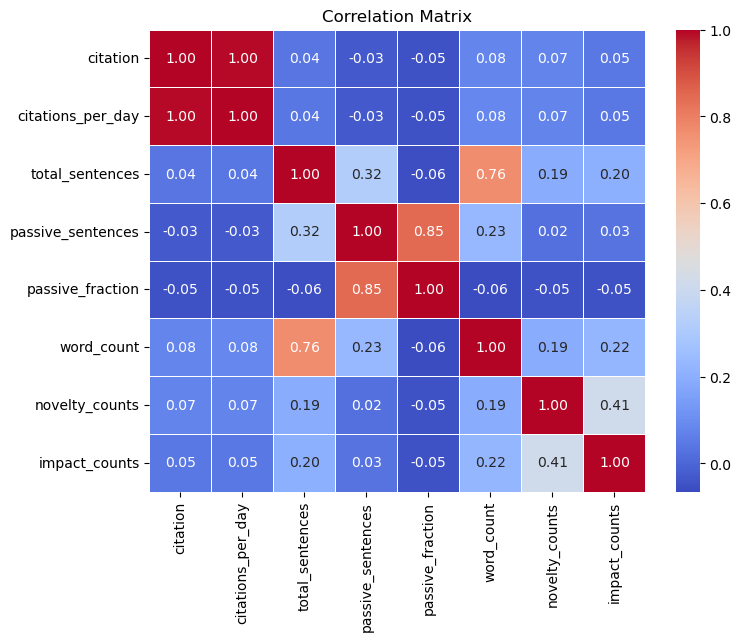

In [369]:
# Select the four columns you want to analyze
columns_to_analyze = ['citation','citations_per_day','total_sentences', 'passive_sentences', 'passive_fraction', 'word_count','novelty_counts','impact_counts']

# Create the correlation matrix
correlation_matrix = df[columns_to_analyze].corr()

# Plot the correlation matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [394]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # For handling SMOTE inside the pipeline

# Download NLTK resources
nltk.download('stopwords')

# Custom Transformer for cleaning, stopword removal, and stemming
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stopwords = set(stopwords.words('english'))  # Using NLTK stopwords
        self.stemmer = PorterStemmer()  # Initialize stemmer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Clean, remove stopwords, and stem each document
        cleaned_text = []
        for text in X:
            # Remove unwanted stopwords, punctuation, and apply stemming
            text = ' '.join([self.stemmer.stem(word) for word in text.split() if word.lower() not in self.stopwords and word.isalpha()])
            cleaned_text.append(text)
        return cleaned_text

# Concatenate title and abstract
X = df['title'] + " " + df['abstract']  # Concatenate title and abstract
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the pipeline with the custom TextCleaner, SMOTE, and Logistic Regression
model = ImbPipeline([
    ('cleaner', TextCleaner()),  # Custom step to clean text, remove stopwords, and apply stemming
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=1000)),  # Feature extraction
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  # Handle imbalance
    ('clf', LogisticRegression(class_weight='balanced', max_iter=500, random_state=42))  # Train classifier
])

# Train model
model.fit(X_train, y_train)

# Cross-validation
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')  # 5-fold cross-validation
print(f'Cross-validation scores: {cross_val_scores}')
print(f'Mean cross-validation score: {cross_val_scores.mean()}')

# Evaluate model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tdejaege/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cross-validation scores: [0.74383844 0.78442074 0.74681764 0.7178752  0.71600992]
Mean cross-validation score: 0.741792386760494
              precision    recall  f1-score   support

       False       0.97      0.84      0.90      3279
        True       0.15      0.54      0.24       173

    accuracy                           0.82      3452
   macro avg       0.56      0.69      0.57      3452
weighted avg       0.93      0.82      0.87      3452



# Simple model to find interesting papers 

Here, I will create a simple model to improve your chances of picking an article that is interesting. We will build the model that can predict if an article will be interesting or not, at the moment it is published. This means we can not use information like how often it was cited to decide if the article is interesting. We use only the abstract and title.

First, we need to define an interesting article. We will use the citation per day

Text(0, 0.5, 'Arbitrary units')

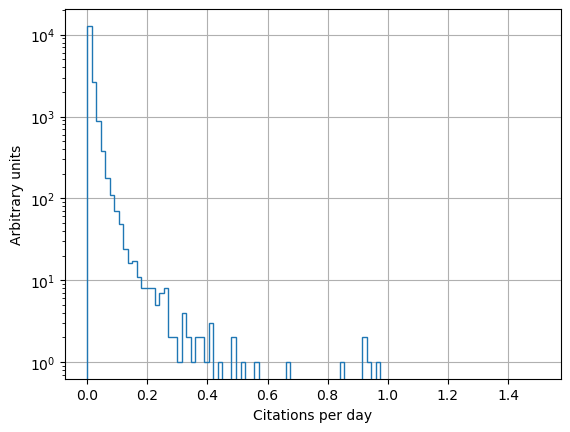

In [225]:
df.citations_per_day.hist(bins=100, range=(0,1.5), log=True, histtype='step')
plt.xlabel("Citations per day")
plt.ylabel("Arbitrary units")

The majority of the paper have not citations. Let's say that only 20% of the paper are interesting,
and we label them.

In [275]:
threshold = df.citations_per_day.quantile(0.95)
df['label'] = df.citations_per_day>threshold
df.label.value_counts(normalize=False)

label
False    16395
True       863
Name: count, dtype: int64

The ColumnExtractor is a handy class for extracting a specific column from a pandas data frame. By using it we can feed a data frame into our pipeline and have different columns extracted from it along the way. We use it to extract the abstract of every article and the title, and then process them separately.



In [298]:
from sklearn.model_selection import cross_val_score,StratifiedKFold,RepeatedStratifiedKFold,GridSearchCV, train_test_split
from sklearn import dummy
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column=0):
        """Extract a column from a pandas.DataFrame
        
        Use this transformer at the beginning of a
        pipeline to extract the column of interest
        from a data frame.
        """
        self.column = column

    def fit_transform(self, X, y=None, **kwargs):
        self.fit(X, y, **kwargs)
        return self.transform(X)

    def transform(self, X, **kwargs):
        return X.iloc[:, self.column]  
    def fit(self, X, y=None, **kwargs):
        return self

In [277]:
# First we split the data
X_train, X_test, y_train, y_test = train_test_split(df,df.label,test_size=0.33,random_state=49)


### Feature Extraction

What to use as features for our classifier. We want to make a prediction as soon as an article is published: title, abstract, authors, full text, etc. Unfortunately citation information is only available after a few weeks or months when people have started citing the article.

A standard approach for text classification is to tokenise the text and then transform it into a high dimensional vector. Each dimension of that vector represents one of the tokens in the input text. A quick demonstration on a bit of nonsense text:


In [278]:
from sklearn.feature_extraction.text import CountVectorizer
# New training and test data
train = ["the cat sat on the mat", "the dog chased the cat"]
test = ["the cat chased the dog", "the dog sat on the mat"]

# Initialize the CountVectorizer
c = CountVectorizer()

# Learn the vocabulary from the training data
c.fit(train)

# Print the mapping of tokens to dimensions (vocabulary)
print("Vocabulary:", c.vocabulary_)

# Transform the test data into numerical vectors
test_vectors = c.transform(test).toarray()

# Print the transformed vectors
print("Test Vectors:\n", test_vectors)

Vocabulary: {'the': 6, 'cat': 0, 'sat': 5, 'on': 4, 'mat': 3, 'dog': 2, 'chased': 1}
Test Vectors:
 [[1 1 1 0 0 0 2]
 [0 0 1 1 1 1 2]]


The vocabulary learned from the training data consists of the following tokens:
{'the': 6, 'cat': 0, 'sat': 5, 'on': 4, 'mat': 3, 'dog': 2, 'chased': 1}

test = ["the cat chased the dog", "the dog sat on the mat"]
The test data is transformed into numerical vectors based on the vocabulary learned from the training data.

Transformed Vectors:

For "the cat chased the dog":

cat appears once (1).
chased appears once (1).
dog appears once (1).
mat does not appear (0).
on does not appear (0).
sat does not appear (0).
the appears twice (2).

Result: [1 1 1 0 0 0 2]

Note: If a token in the test data is not present in the vocabulary (e.g., a new word), it is ignored by default in CountVectorizer.

***The vectorizer by itself is not enough though, using the raw counts of each token has several problems including:***

    -> it does not take into account the overall length of a document
    -> uninformative words like "the" or "and" which appear in every document receive a very high count


In [279]:
'''
Both of these are addressed by the second step of the pipeline which turns the raw counts into a
term-frequency times inverse document-frequency vector. 
Term-frequencey is the count of a token divided by the total number of tokens in a document. 
Inverse document-frequency scales down tokens found in a large number of documents, thereby giving them less weight.
'''
t = TfidfTransformer()
t.fit(c.transform(train))
print(t.transform(c.transform(test)).toarray())



[[0.33425073 0.46977774 0.46977774 0.         0.         0.
  0.66850146]
 [0.         0.         0.40740124 0.40740124 0.40740124 0.40740124
  0.57973867]]


## Pipeline

Let's assemble our complete pipeline. Both the title and abstract pipelines use bi-grams as tokens isntead of simple words, as well as a modified token_pattern which does not match numbers, only words.

In [299]:
# pretty names for the dataframe column indices 
TITLE = 0
ABSTRACT = 1

# sub-pipeline for extracting the abstract
vect = CountVectorizer(stop_words='english',token_pattern=u'(?u)\\b[A-z][A-z]+\\b')
#Convert text into word counts
#Remove common English stop words
# Extract words with at least two letters
abstract_pipe = Pipeline([('abstracts', ColumnExtractor(ABSTRACT)),
                          ('vect', vect),
                          ('tfidf', TfidfTransformer())
                          ])

# sub-pipeline for extracting the title
title_pipe = Pipeline([('title', ColumnExtractor(TITLE)),
                       ('vect', CountVectorizer(stop_words='english',
                                                token_pattern=u'(?u)\\b[A-z][A-z]+\\b')),
                       ('tfidf', TfidfTransformer())
                       ])
# combined pipeline
text_clf = Pipeline([('features', FeatureUnion([('abstract', abstract_pipe),
                                                ('title', title_pipe)])),('clf', RandomForestClassifier(n_estimators=100, random_state=42))])                     # use DummyClassifier to convince yourself we do better
                     # than pure luck
                     #('clf', dummy.DummyClassifier())
        

In [300]:
scores = cross_val_score(text_clf, X_train, y_train,cv=3, scoring='roc_auc')
scores

array([0.68361661, 0.68480597, 0.70405368])

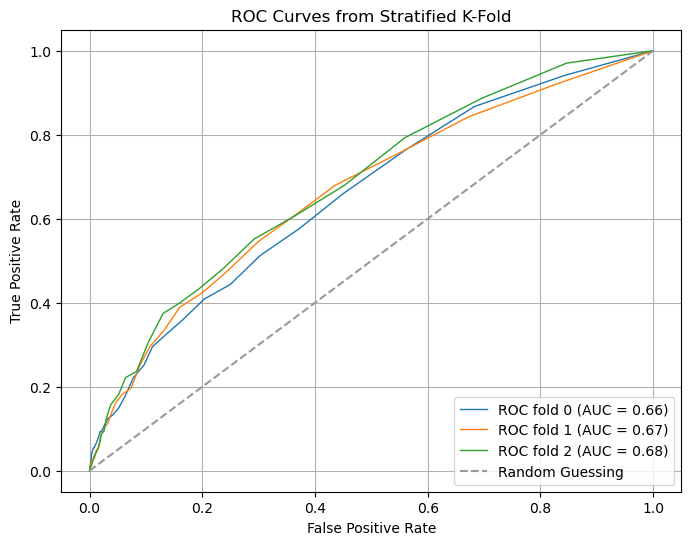

In [301]:
from sklearn.model_selection import StratifiedKFold

# Initialize StratifiedKFold with correct parameters
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=49)

plt.figure(figsize=(8, 6))

for i, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    # Train on the fold
    text_clf.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    
    # Predict probabilities for the test fold
    probas_ = text_clf.predict_proba(X_train.iloc[test_idx])
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_train.iloc[test_idx], probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, lw=1, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')

# Add diagonal line and labels
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves from Stratified K-Fold')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# From SCRATCH

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tdejaege/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Logistic Regression - Mean AUC: 0.7654
Random Forest - Mean AUC: 0.7300
SVM - Mean AUC: 0.7817


/home/tdejaege/anaconda3/envs/lemaitre/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:20:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/tdejaege/anaconda3/envs/lemaitre/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:20:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/tdejaege/anaconda3/envs/lemaitre/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:21:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Mean AUC: 0.7285


/home/tdejaege/anaconda3/envs/lemaitre/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:21:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


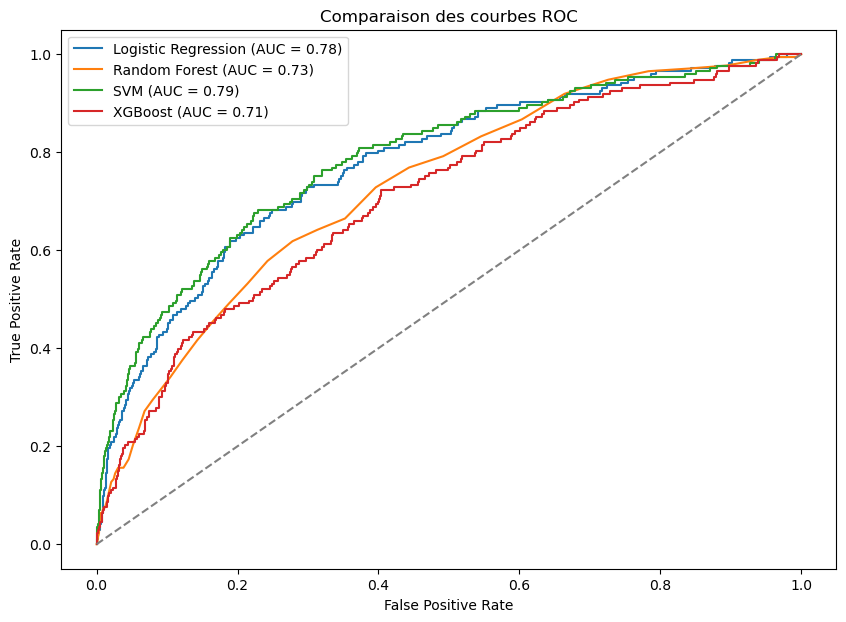

In [430]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Download NLTK resources
nltk.download('stopwords')

# Custom Transformer for cleaning, stopword removal, and stemming
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stopwords = set(stopwords.words('english'))  # Using NLTK stopwords
        self.stemmer = PorterStemmer()  # Initialize stemmer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Clean, remove stopwords, and stem each document
        cleaned_text = []
        for text in X:
            # Remove unwanted stopwords, punctuation, and apply stemming
            text = ' '.join([self.stemmer.stem(word) for word in text.split() if word.lower() not in self.stopwords and word.isalpha()])
            cleaned_text.append(text)
        return cleaned_text

# Concatenate title and abstract
X = df['title'] + " " + df['abstract'] 
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plt.figure(figsize=(10, 7))

for name, model in models.items():
    # Pipeline
    clf_pipeline = ImbPipeline([
        ('cleaner', TextCleaner()),
        ('tfidf', TfidfVectorizer(stop_words='english', max_features=1000)),  # Feature extraction
        ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
        ('clf', model)
    ])

    # Cross-validation
    auc_scores = cross_val_score(clf_pipeline, X, y, cv=cv, scoring='roc_auc')
    print(f'{name} - Mean AUC: {auc_scores.mean():.4f}')
    
    # train model
    clf_pipeline.fit(X_train, y_train)
    
    # Predictions 
    y_probs = clf_pipeline.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)
    
    # ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Affichage des résultats
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Ligne de référence
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparaison des courbes ROC')
plt.legend()
plt.show()


### Fine tune best model

In [10]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.stopwords = None  # Déclaration mais chargement différé

    def fit(self, X, y=None):
        from nltk.corpus import stopwords  # Import ici pour éviter les conflits avec joblib
        nltk.download('stopwords', quiet=True)  # Télécharger seulement si nécessaire
        self.stopwords = set(stopwords.words('english'))
        return self  # Rien à apprendre

    def transform(self, X):
        return [
            ' '.join(
                [self.stemmer.stem(word) for word in text.split() if self.stopwords and word.lower() not in self.stopwords and word.isalpha()]
            )
            for text in X
        ]

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] END ....clf__C=0.1, clf__gamma=auto, clf__kernel=linear; total time=14.2min
[CV] END ......clf__C=0.1, clf__gamma=auto, clf__kernel=poly; total time=19.0min
[CV] END ........clf__C=0.1, clf__gamma=0.1, clf__kernel=rbf; total time=17.4min
[CV] END .......clf__C=1, clf__gamma=scale, clf__kernel=poly; total time=21.6min
[CV] END ........clf__C=1, clf__gamma=0.01, clf__kernel=poly; total time=20.9min
[CV] END ......clf__C=10, clf__gamma=scale, clf__kernel=poly; total time=25.5min
[CV] END ......clf__C=10, clf__gamma=0.1, clf__kernel=linear; total time= 7.2min
[CV] END .....clf__C=0.1, clf__gamma=scale, clf__kernel=poly; total time=18.1min
[CV] END .......clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf; total time=19.1min
[CV] END .......clf__C=0.1, clf__gamma=0.1, clf__kernel=poly; total time=19.1min
[CV] END ........clf__C=1, clf__gamma=auto, clf__kernel=poly; total time=19.7min
[CV] END ..........clf__C=1, clf__gamma=0.1, clf

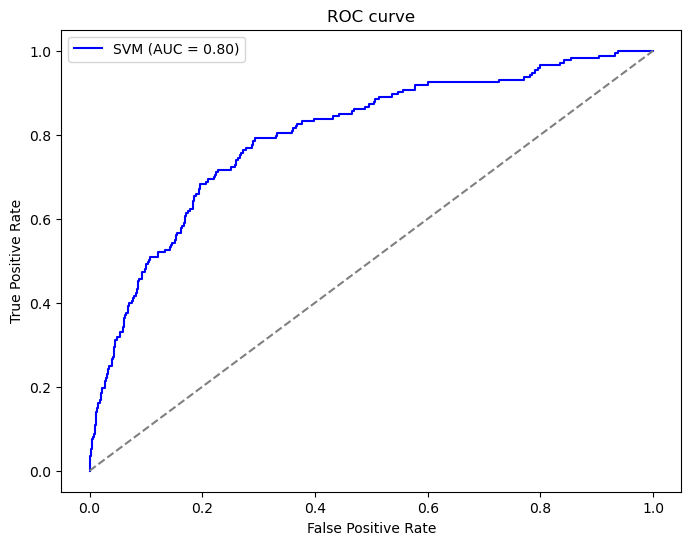

In [11]:
from sklearn.model_selection import GridSearchCV
# Concatenate title and abstract
X = df['title'] + " " + df['abstract'] 
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# grid
param_grid = {
    'clf__C': [0.1, 1, 10],  # regularisation
    'clf__kernel': ['linear', 'rbf', 'poly'],  # kernel
    'clf__gamma': ['scale', 'auto', 0.01, 0.1]  # 
}

# Pipeline
svm_pipeline = ImbPipeline([
    ('cleaner', TextCleaner()),
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('clf', SVC(probability=True, class_weight='balanced', random_state=42))
])

# cross validation
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=2, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres trouvés
print(f"Best params : {grid_search.best_params_}")
print(f"Best ROC AUC score : {grid_search.best_score_:.4f}")

# Best model on test data
best_svm = grid_search.best_estimator_  
y_probs = best_svm.predict_proba(X_test)[:, 1]

# ROC curve

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()


In [ ]:
import torch
from transformers import BartTokenizer, BartForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import pandas as pd
# Load dataset
df = pd.read_parquet("arxiv.parquet")

# Ensure required columns exist
if not {'title', 'abstract', 'label'}.issubset(df.columns):
    raise ValueError("Dataset must contain 'title', 'abstract', and 'label' columns")

# Preprocess data
df.dropna(subset=['title', 'abstract', 'label'], inplace=True)
df['text'] = df['title'] + ' ' + df['abstract']
df['label'] = df['label'].astype(int)  # Ensure labels are integers

# Split dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# Load tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels}).map(tokenize_function, batched=True)
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels}).map(tokenize_function, batched=True)

# Load model
model = BartForSequenceClassification.from_pretrained("facebook/bart-base", num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train model
trainer.train()

# Save model
model.save_pretrained("./bart_model")
tokenizer.save_pretrained("./bart_model")

In [ ]:
#model predictions
preds_output = trainer.predict(val_dataset)

# Extract logits correctly
logits = preds_output.predictions
if isinstance(logits, tuple):  # Some models return tuples
    logits = logits[0]

# Debugging: Check if logits are correctly extracted
print(f"Logits type: {type(logits)}")  # Should be numpy array or tensor
print(f"Logits shape: {logits.shape}")  # Should be (num_samples, num_classes)

# Convert logits to class labels
y_pred = logits.argmax(axis=1)

# Extract true labels
y_true = preds_output.label_ids

# Compute performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")